# Clustering

## Preparation

In [1]:
import pandas as pd
import numpy as np
#import datetime
from sklearn.model_selection import train_test_split
import matplotlib as mpl
import matplotlib.pyplot as plt
#from matplotlib.dates import DateFormatter, WeekdayLocator,\
 #   DayLocator, MONDAY
#import matplotlib.dates as mdates
import seaborn as sns
#from pandas.api.types import CategoricalDtype

#clustering
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse
from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

import warnings;
warnings.filterwarnings('ignore');

In [2]:
#reading in data and prepare for Frankfurt 2015 and 2016
#just clustering on both years, no separate clustering since it does not seem useful

We are going to cluster the stations first. Station names and IDs would just appear as index, hence data points in a cluster, still they would be added together for all NaN in one cluster. We do not know what NaN means for certain stations. Did it mean that the station simply wasn't added to the data or that the bike isn't at a specific station? Since we cannot know this for sure, we will drop all the rows with NaN values.

In [3]:
# 1. read data
# 2. drop NaN values
# 3. split for Frankfurt
# 4. split for right timing
# 5. change other date formats 
# 6. add duration column
booking_set = pd.read_csv("OPENDATA_BOOKING_CALL_A_BIKE.csv", delimiter=';')
booking_set = booking_set.dropna()

In [4]:
booking_set_frankfurt = booking_set[booking_set['CITY_RENTAL_ZONE'].str.contains('Frankfurt')]

In [5]:
booking_set_frankfurt.sort_values(['DATE_BOOKING'], axis=0, 
                 ascending=True, inplace=True) #sort the data after the date, ascending
booking_set_frankfurt['DATE_BOOKING'] = pd.to_datetime(booking_set_frankfurt['DATE_BOOKING'])
booking_set_frankfurt['DATE_BOOKING'].dt.strftime('%Y-%m-%d %X')
start_date_20152016 = '2015-01-01 00:00:00'
end_date_20152016 = '2016-12-31 23:59:59'
filtered_dates_20152016 = (booking_set_frankfurt['DATE_BOOKING'] >= start_date_20152016) & (booking_set_frankfurt['DATE_BOOKING'] <= end_date_20152016)
booking_set_frankfurt_20152016 = booking_set_frankfurt.loc[filtered_dates_20152016]

In [6]:
booking_set_frankfurt_20152016['DATE_UNTIL'] = pd.to_datetime(booking_set_frankfurt_20152016['DATE_UNTIL'])
booking_set_frankfurt_20152016['DATE_UNTIL'].dt.strftime('%Y-%m-%d %X')
booking_set_frankfurt_20152016['DATE_FROM'] = pd.to_datetime(booking_set_frankfurt_20152016['DATE_FROM'])
booking_set_frankfurt_20152016['DATE_FROM'].dt.strftime('%Y-%m-%d %X')
booking_set_frankfurt_20152016['duration'] = booking_set_frankfurt_20152016['DATE_UNTIL'] - booking_set_frankfurt_20152016['DATE_FROM']


## Cluster stations by customer types

### Preparation

In [7]:
#check how many unique ustomers a station has
#make two columns, one with the amount of customers a station that has over 100 bookings for that station
#and one with the rest of customers that has under 100 bookings
cluster = booking_set_frankfurt_20152016.loc[:,['BOOKING_HAL_ID', 'START_RENTAL_ZONE_HAL_ID', 'CUSTOMER_HAL_ID']]
a = cluster.groupby(['START_RENTAL_ZONE_HAL_ID', 'CUSTOMER_HAL_ID'], as_index = False)['BOOKING_HAL_ID'].count()
a2 = cluster.groupby(['START_RENTAL_ZONE_HAL_ID'], as_index = False).agg({'CUSTOMER_HAL_ID': pd.Series.nunique})
c = a.loc[a['BOOKING_HAL_ID'] > 100]

In [8]:
c2 = c.groupby(['START_RENTAL_ZONE_HAL_ID'], as_index = False).agg({'CUSTOMER_HAL_ID': pd.Series.nunique})
c2 = c2.rename(columns={"CUSTOMER_HAL_ID" : "over_100_bookings"})
a2 = a2.set_index('START_RENTAL_ZONE_HAL_ID')
c2 = c2.set_index('START_RENTAL_ZONE_HAL_ID')

In [9]:
result = pd.concat([a2, c2], axis=1)
result.fillna(0, inplace=True)

In [10]:
result['under_100_bookings'] = result['CUSTOMER_HAL_ID'] - result['over_100_bookings']
result = result.drop('CUSTOMER_HAL_ID', axis=1)                                                   

In [11]:
#remove outliers
indexNames = result[ result['over_100_bookings'] > 40 ].index
indexNames
result = result.drop(indexNames)


### K-Means

In [12]:
#scale values
scaler = StandardScaler()
scaler.fit(result)
X_scaled = scaler.transform(result)
X_scaled_df = pd.DataFrame(X_scaled, columns=result.columns, index=result.index)
X_scaled_df.head()

,over_100_bookings,under_100_bookings
START_RENTAL_ZONE_HAL_ID,,
3710.0,-0.224552,-0.356550
3717.0,-0.526146,-0.618293
3916.0,-0.224552,0.640325
3954.0,-0.224552,0.123995
3961.0,-0.526146,3.058384


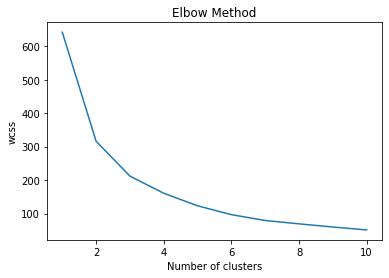

In [13]:
#check for optimal amount of clusters
wcss = []
for i in range(1,11):
    km=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(X_scaled_df)
    wcss.append(km.inertia_)
plt.plot(range(1,11),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

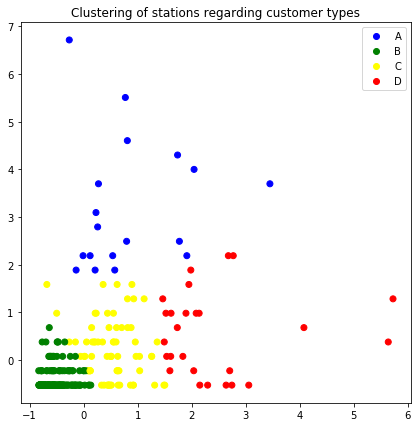

In [14]:
#plot the k-means
classes = ['A', 'B', 'C', 'D']
colours = ListedColormap(["blue", "green", "yellow", "red"])

means = KMeans(n_clusters=4, init='k-means++', max_iter=300, algorithm='auto')
means.fit(X_scaled_df)
means.predict(X_scaled_df)
x_pred = means.predict(X_scaled_df)
plt.subplots(1, 1, figsize=(7,7))
scatter = plt.scatter(X_scaled[:, 1], X_scaled[:, 0], c=x_pred, cmap=colours)
plt.title("Clustering of stations regarding customer types")
plt.legend(handles=scatter.legend_elements()[0], labels=classes)

plt.show()

Here 4 Clusters (possible up to 6):
- green: small size of regular and occasional customers 
- yellow: medium to big size of regular customers with up to medium occasional
- red: medium size of regular customers, small to medium size of occasional customers
- blue: small size of regular customers, medium to big size occasional customers


### Result: 

After testing all three clustering algorithms, K-Means had the best result, hence remains.

### Explanation: 

The stations with little occasional customers and many permanent ones, are probably going to schools or areas with working places where there is no need to go to on occasion since eg. shopping center etc is missing. Whereas the other way around with many occasional customers are places where not many are going often, eg shopping centers or parks etc. The outliers should be looked at separately, but again it is most likely train stations. What would be a senseful cluster number-wise?

## Cluster the stations by amount of bookings and hour

Let's think about what actually makes sense to cluster stations for? Would the duration make sense as an attribute for a station? Problably not. Monthly rentals might reduce over time with bad weather but hourly data could still make a difference. How many bookings and vehicles are on the stations over the day? This will most likely produce another linear outcome, but maybe it will point something out.

### Preparation

In [15]:
#cluster the statuons with amount of bookings during the hour
#to prevent the multiple listing of unique stations, just choose the hour where the station had the highest
#amount of bookings 
cluster = booking_set_frankfurt_20152016.loc[:,['BOOKING_HAL_ID', 'START_RENTAL_ZONE_HAL_ID', 'VEHICLE_HAL_ID', 'DATE_BOOKING']]
cluster['hour'] = cluster['DATE_BOOKING'].dt.strftime('%H')

In [16]:
second_cluster = cluster.groupby(['START_RENTAL_ZONE_HAL_ID', 'hour'], as_index = False)['BOOKING_HAL_ID'].count()
second_cluster = second_cluster.rename(columns={"START_RENTAL_ZONE_HAL_ID": "id"})
second_cluster = second_cluster.rename(columns={"BOOKING_HAL_ID": "amount"})

In [17]:
indices = second_cluster.groupby('id')['amount'].idxmax
second_cluster = second_cluster.loc[indices]
second_cluster = second_cluster.set_index('id')
second_cluster = second_cluster.sort_values(by='hour')

In [18]:
#drop the outliers with over 4000 bookings
indexNames = second_cluster[ second_cluster['amount'] > 4000 ].index
indexNames
second_cluster = second_cluster.drop(indexNames)
second_cluster

,hour,amount
id,,
252298.0,00,21
250934.0,00,24
254653.0,00,16
258998.0,05,26
232598.0,07,429
...,...,...
227471.0,21,123
250669.0,22,268
231638.0,22,93


### K-Means

In [19]:
#scale values
scaler = StandardScaler()
scaler.fit(second_cluster)
X_scaled = scaler.transform(second_cluster)
X_scaled_df = pd.DataFrame(X_scaled, columns=second_cluster.columns, index=second_cluster.index)
X_scaled_df.head()

,hour,amount
id,,
252298.0,-2.542524,-0.764249
250934.0,-2.542524,-0.757553
254653.0,-2.542524,-0.775410
258998.0,-1.540867,-0.753088
232598.0,-1.140204,0.146466


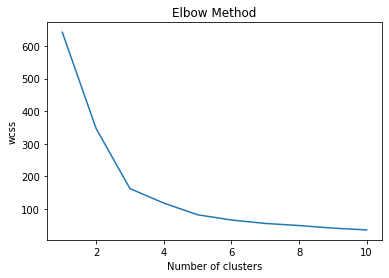

In [20]:
#check for optimal amount of clusters
wcss = []
for i in range(1,11):
    km=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(X_scaled_df)
    wcss.append(km.inertia_)
plt.plot(range(1,11),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

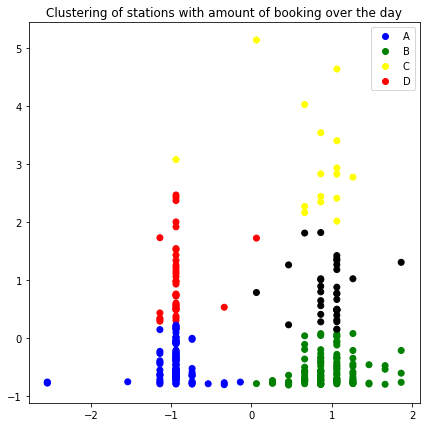

In [21]:
#plot the k-means

classes = ['A', 'B', 'C', 'D', 'E']
colours = ListedColormap(["blue", "green", "yellow", "red", "black"])

means = KMeans(n_clusters=5, init='k-means++', max_iter=300, algorithm='auto')
means.fit(X_scaled_df)
means.predict(X_scaled_df)
x_pred = means.predict(X_scaled_df)
plt.subplots(1, 1, figsize=(7,7))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=x_pred, cmap=colours)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.title("Clustering of stations with amount of booking over the day")

plt.show()




### Hierarchical Clustering

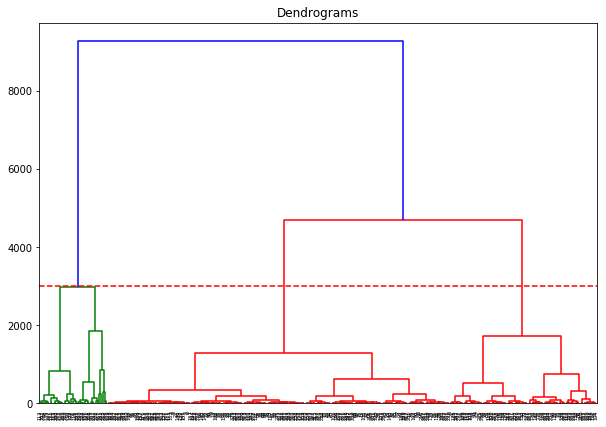

In [22]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")
dend = shc.dendrogram(shc.linkage(second_cluster, method='ward'))
plt.axhline(y=3000, color='r', linestyle='--')

In [23]:
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')  
cluster.fit_predict(second_cluster)

array([2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 3, 1,
       2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 1,
       1, 1, 2, 2, 3, 1, 2, 3, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1,
       1, 3, 1, 3, 1, 3, 1, 2, 1, 3, 1, 2, 0, 0, 1, 0, 3, 1, 1, 1, 1, 2,
       1, 3, 3, 2, 1, 1, 1, 1, 2, 0, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1,
       2, 2, 1, 2, 2, 2, 1, 0, 3, 2, 2, 2, 1, 3, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 0, 2, 0, 1, 1, 2, 2, 2, 2, 2, 2, 1,
       1, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 0, 3, 2, 2, 2, 2, 0, 2,
       2, 2, 2, 2, 2, 2, 0, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 2,
       2, 1, 1, 3, 1, 3, 3, 0, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1,
       2, 1, 2, 2, 2, 2, 2, 2, 2, 3, 2, 1, 1, 1, 2, 0, 3, 0, 1, 1, 2, 1,
       1, 2, 1, 2, 0, 3, 0, 2, 2, 2, 1, 2, 2, 2, 2,

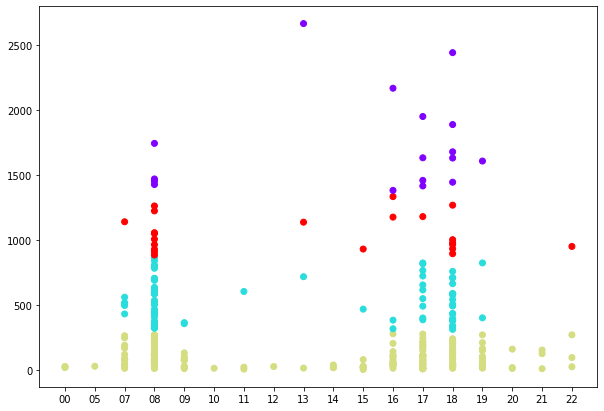

In [24]:
plt.figure(figsize=(10, 7))
plt.scatter(second_cluster['hour'], second_cluster['amount'], c=cluster.labels_, cmap='rainbow')

### Result:

There are a lot of stations that have their highest of bookinf over the day, even though this is still a very low amount of bookings. There are again very few that have an unnaturally high amount. This falls into the time of the working hours, so might be a true result. It might as well be outliers though. Majority of clusters makes a break at around 1000 bookings and starts the second cluster until around 30000. After that just the "outliers" form a cluster. No cluster algorithm showed clusters in the sense of separating into different hour intervals, which might be a result of the distance metrics. However, it seems reasonable that most stations have their high point around the working hours. In between there are relatively few stations that have their highest point. 

Technically doesn't it make sense to seperate again into stations with small size, medium size and large size of customers for each morning till lunch and then afternoon and night? Maybe a destinction of stations used at night etc would have made more sense? 

### Explanation: 

Also here, it seems that k-means has the best clustering that makes sense. 4 clusters, one with few customers over the daytime, one with few customers in the afternoon, one with many customers over the daytime, one with many customers in the later hours.

## Stations with the amount of bookings and customers

###  Preparation

In [25]:
#get one cluster with the amount of bookings a station 
# one cluster with the amount of unique customers a station 
#combine those clusters to one table
cluster = booking_set_frankfurt_20152016.loc[:,['BOOKING_HAL_ID', 'START_RENTAL_ZONE_HAL_ID', 'CUSTOMER_HAL_ID']]
cluster4 = cluster.groupby(['START_RENTAL_ZONE_HAL_ID'], as_index = False)['BOOKING_HAL_ID'].count()
cluster4 = cluster4.set_index('START_RENTAL_ZONE_HAL_ID')

In [26]:
cluster5 = cluster.groupby(by='START_RENTAL_ZONE_HAL_ID', as_index=False).agg({'CUSTOMER_HAL_ID': pd.Series.nunique})
cluster5 = cluster5.set_index('START_RENTAL_ZONE_HAL_ID')
cluster4 = cluster4.merge(cluster5, left_index=True, right_index=True)

In [27]:
#drop out the outliers with over 10000 customers
indexNames = cluster4[ cluster4['CUSTOMER_HAL_ID'] > 10000 ].index
indexNames
cluster4 = cluster4.drop(indexNames)

### K-Means

In [28]:
#scale values
scaler = StandardScaler()
scaler.fit(cluster4)
X_scaled = scaler.transform(cluster4)
X_scaled_df = pd.DataFrame(X_scaled, columns=cluster4.columns, index=cluster4.index)
X_scaled_df.head()

,BOOKING_HAL_ID,CUSTOMER_HAL_ID
START_RENTAL_ZONE_HAL_ID,,
3710.0,-0.270326,-0.363853
3717.0,-0.569365,-0.623753
3916.0,0.233606,0.622149
3954.0,-0.267105,0.111451
3961.0,1.490710,3.012825


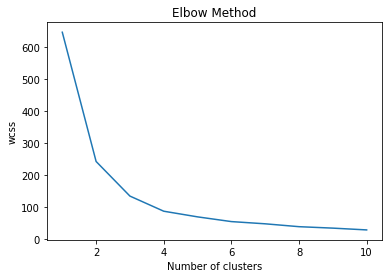

In [29]:
#check for optimal amount of clusters
wcss = []
for i in range(1,11):
    km=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(X_scaled_df)
    wcss.append(km.inertia_)
plt.plot(range(1,11),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

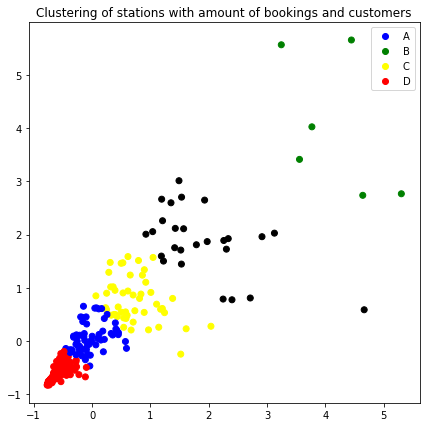

In [30]:
#plot the k-means
classes = ['A', 'B', 'C', 'D', 'E']
colours = ListedColormap(["blue", "green", "yellow", "red", "black"])

means = KMeans(n_clusters=5, init='k-means++', max_iter=300, algorithm='auto')
means.fit(X_scaled_df)
means.predict(X_scaled_df)
x_pred = means.predict(X_scaled_df)
plt.subplots(1, 1, figsize=(7,7))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=x_pred, cmap=colours)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)

plt.title("Clustering of stations with amount of bookings and customers")

plt.show()

### Gaussian Mixture

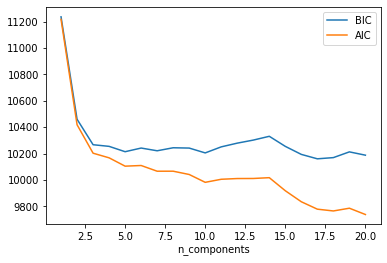

In [31]:
#The optimal number of clusters is the value that minimizes the AIC or BIC
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(cluster4)
          for n in n_components]

plt.plot(n_components, [m.bic(cluster4) for m in models], label='BIC')
plt.plot(n_components, [m.aic(cluster4) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

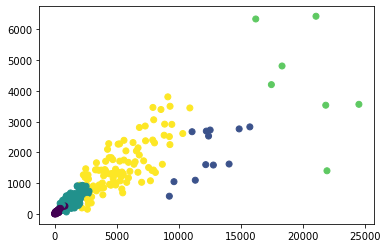

In [32]:
gmm = GaussianMixture(n_components=5).fit(cluster4)
labels = gmm.predict(cluster4)
plt.scatter(cluster4['BOOKING_HAL_ID'], cluster4['CUSTOMER_HAL_ID'], c=labels, cmap='viridis')

###  Hierarchical Clustering

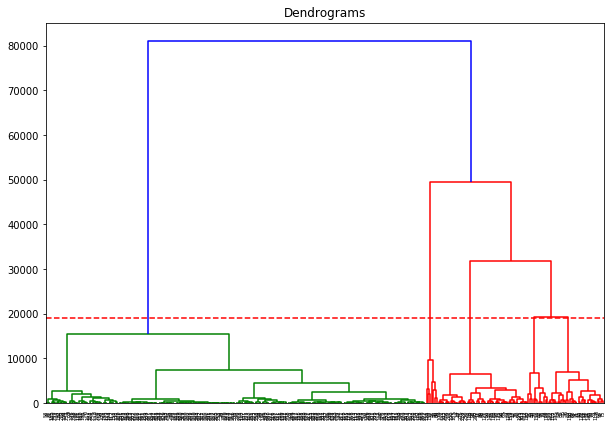

In [33]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")
dend = shc.dendrogram(shc.linkage(cluster4, method='ward'))
plt.axhline(y=19000, color='r', linestyle='--')
#we could also place the line further up and make it less clusters

In [34]:
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='average')  
cluster.fit_predict(cluster4)

array([4, 4, 1, 4, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 4, 1, 1, 1, 4, 1, 1, 1,
       1, 4, 4, 2, 4, 1, 4, 4, 1, 1, 2, 4, 4, 1, 4, 0, 4, 2, 2, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 1, 1, 4, 4, 1, 1, 2, 1, 0, 1,
       1, 2, 3, 2, 2, 1, 1, 2, 1, 1, 4, 1, 1, 2, 1, 4, 4, 1, 1, 1, 4, 4,
       4, 1, 1, 4, 4, 1, 4, 1, 1, 4, 1, 4, 1, 4, 4, 1, 4, 4, 4, 4, 4, 1,
       4, 4, 4, 4, 1, 1, 1, 4, 4, 4, 4, 1, 4, 1, 4, 2, 4, 4, 1, 4, 4, 4,
       4, 1, 4, 4, 4, 4, 1, 4, 1, 4, 1, 4, 4, 1, 4, 4, 4, 4, 1, 4, 4, 4,
       4, 3, 2, 3, 4, 1, 4, 4, 1, 1, 4, 1, 4, 4, 4, 4, 4, 4, 1, 4, 4, 1,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4,
       4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 1, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

Text(0.5, 1.0, 'Clstering of Stations for Bookings and Customers')

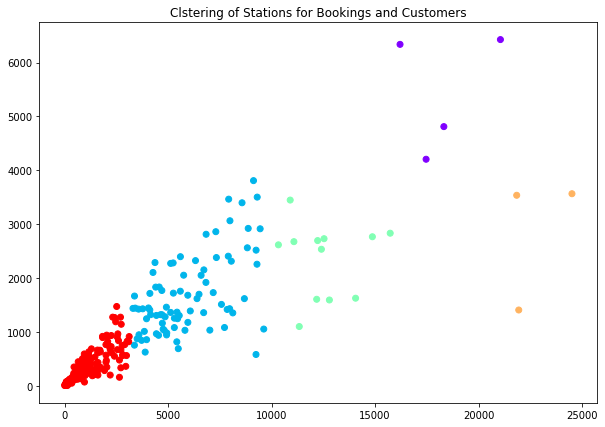

In [35]:
#plot the HC
plt.figure(figsize=(10, 7))
plt.scatter(cluster4['BOOKING_HAL_ID'], cluster4['CUSTOMER_HAL_ID'], c=cluster.labels_, cmap='rainbow')
plt.title("Clstering of Stations for Bookings and Customers")

### Result: 

There is one cluster with very little customers and bookings, the lines are roughly 2000 customer and 4000 bookings. Another cluster has a wider area but still more customers, the lines are roughly 17000 bookings and 4000 customers. Then the next cluster has barely any stations but still a few. The lines are wide. There are those that have relatively little bookings but many customers and the other way around, little customers but many bookings. Then again there is one station that is far away from all others and makes it own cluster with many bookings and many customers. 

The HC seems the most accurate: 
- Cluster 1: small size of bookingd and customers
- Cluster 2: medium size of bookings and customers
- Cluster 3: higher amount of bookings than Cluster 2
- Cluster 4: high amount of bookings and customers
- Cluster 5: high amount of bookings and medium amount of customers

### Explanation: 

Most likely, the first cluster with very few customers and bookings are stations that aren't used very often. The next cluster with a higher variance, sometimes relatively much bookings with a few customers might be those stations that are used by customers going to work or school, also possible would be shopping centers etc. that are often used. Then next clusters are most probably those that go to very specific places, e.g. a train station. It might be possible to find more information when we see when these stations are accessed. 

- After removal of the one outlier:
The last HC cluster seems to make enough sense with 5 clusters.
- red: stations with few customers and bookings
- blue: stations with medium customers and bookings
- mint: stations with medium customers and many bookings
- violet: stations with many customers and many bookings
- stations with medium customers and the most bookings

# Clusters with the weather data

## Cluster the amount of bookings to the temperature

### Preparation

In [36]:
#read in weather data and cluster the amount of rentals per temperature
booking_set = pd.read_csv("DataBase_WeatherRentalAmountStations_UTC.csv")
bookings_temp = booking_set.groupby(['Temperature'], as_index = False)['Rentals'].sum()

### K-Means

In [37]:
scaler = StandardScaler()
scaler.fit(bookings_temp)
X_scaled = scaler.transform(bookings_temp)
X_scaled_df = pd.DataFrame(X_scaled, columns=bookings_temp.columns, index=bookings_temp.index)
X_scaled_df.head()

,Temperature,Rentals
0,-1.750592,-1.394490
1,-1.742598,-1.288377
2,-1.726610,-1.358628
3,-1.710622,-1.384665
4,-1.694634,-1.392525


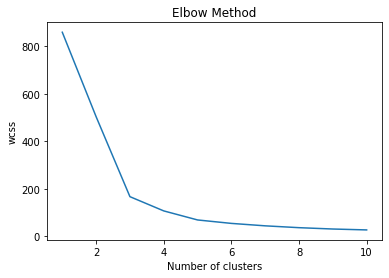

In [38]:
#check for optimal amount of clusters
wcss = []
for i in range(1,11):
    km=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(X_scaled_df)
    wcss.append(km.inertia_)
plt.plot(range(1,11),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

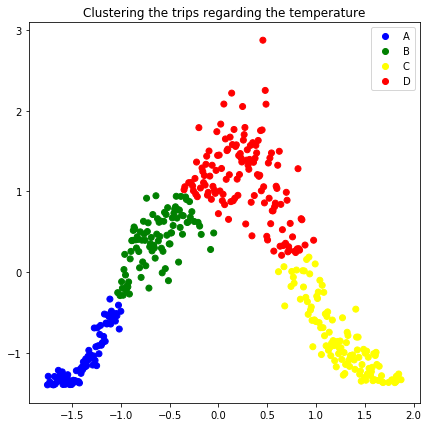

In [39]:
#plot the k-means
classes = ['A', 'B', 'C', 'D']
colours = ListedColormap(["blue", "green", "yellow", "red"])

means = KMeans(n_clusters=4, init='k-means++', max_iter=300, algorithm='auto')
means.fit(X_scaled_df)
means.predict(X_scaled_df)
x_pred = means.predict(X_scaled_df)
plt.subplots(1, 1, figsize=(7,7))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=x_pred, cmap=colours)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)

plt.title("Clustering the trips regarding the temperature")

plt.show()

### Explanation 
You can see those trips that are going at a very low temperature, those at a high temperature and then going upwards with the amount of trips. So the most trips were made averagely between 10 to 20 degrees. However, it would make sense to put more clusters so low and high temperature dont get put together (that is what happened with HC that has been removed by now).
So the K-Means actually has a way better distribution with the 5 clusters.

- Cluster 1: low temperature, small size
- Cluster 2: low to med temp and med size
- Cluster 3: med temp and high size
- Cluster 4: high temp to med size and small size

# Clustering with Customers

## Customer to their amount of bookings and the mean duration

### Preparation

#### Preparation of the cluster tables

In [40]:
#count the amount of bookings per customers
#then count the average duration for these bookings
#combine the tables
cluster = booking_set_frankfurt_20152016.loc[:,['BOOKING_HAL_ID', 'duration', 'CUSTOMER_HAL_ID']]

In [41]:
cluster7 = cluster.groupby(by='CUSTOMER_HAL_ID', as_index=False)['BOOKING_HAL_ID'].count()
cluster7 = cluster7.drop('CUSTOMER_HAL_ID', axis=1)

In [42]:
cluster['duration'] = pd.to_numeric(cluster['duration'])
cluster8 = cluster.groupby(["CUSTOMER_HAL_ID"], as_index = False)['duration'].mean()
cluster8['duration'] = pd.to_timedelta(cluster8['duration'])
cluster8['duration']  = round(cluster8['duration'].dt.total_seconds()/60)
cluster8 = cluster8.drop('CUSTOMER_HAL_ID', axis=1)

In [43]:
cluster7 = pd.concat([cluster7, cluster8], axis=1)

In [44]:
#drop customers with too long bookings
indexNames = cluster7[ cluster7['duration'] > 10000 ].index
indexNames2 = cluster7[cluster7['duration'] < 60].index

In [45]:
cluster7 = cluster7.drop(indexNames)
cluster8 = cluster7.drop(indexNames2)

### K-Means

In [46]:
#scale values
scaler = StandardScaler()
scaler.fit(cluster7)
X_scaled = scaler.transform(cluster7)
X_scaled_df = pd.DataFrame(X_scaled, columns=cluster7.columns, index=cluster7.index)
X_scaled_df.head()

,BOOKING_HAL_ID,duration
0,-0.315646,-0.020584
1,1.634351,-0.184906
2,-0.331630,-0.210851
3,-0.347613,-0.176257
4,-0.187778,-0.171933


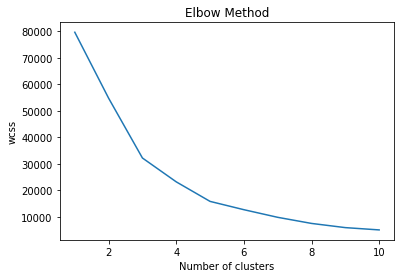

In [47]:
#check for optimal amount of clusters
wcss = []
for i in range(1,11):
    km=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(X_scaled_df)
    wcss.append(km.inertia_)
plt.plot(range(1,11),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

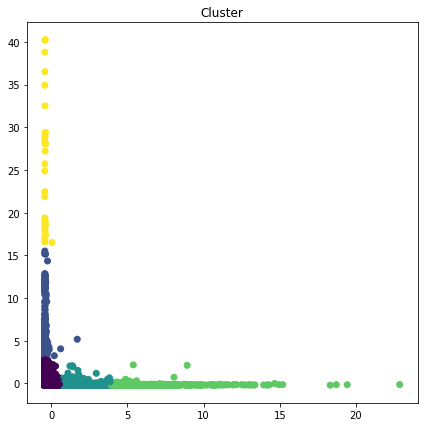

In [48]:
#plot the k-means
means = KMeans(n_clusters=5, init='k-means++', max_iter=300, algorithm='auto')
means.fit(X_scaled_df)
means.predict(X_scaled_df)
x_pred = means.predict(X_scaled_df)
plt.subplots(1, 1, figsize=(7,7))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=x_pred)
plt.title("Cluster")

plt.show()

In [49]:
#scale values
scaler = StandardScaler()
scaler.fit(cluster8)
X_scaled = scaler.transform(cluster8)
X_scaled_df = pd.DataFrame(X_scaled, columns=cluster8.columns, index=cluster8.index)
X_scaled_df.head()

,BOOKING_HAL_ID,duration
14,-0.027614,-0.298859
16,-0.069142,-0.353959
18,-0.069142,0.658037
21,1.550440,-0.374162
24,-0.193725,-0.069278


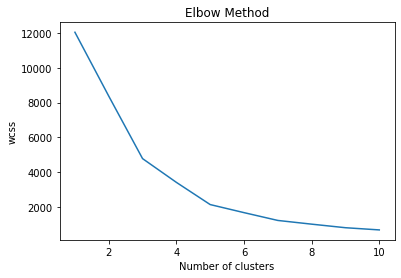

In [50]:
#check for optimal amount of clusters
wcss = []
for i in range(1,11):
    km=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(X_scaled_df)
    wcss.append(km.inertia_)
plt.plot(range(1,11),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

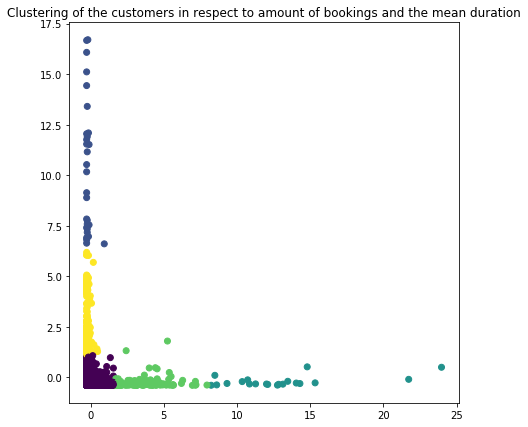

In [51]:
#plot the k-means
means = KMeans(n_clusters=5, init='k-means++', max_iter=300, algorithm='auto')
means.fit(X_scaled_df)
means.predict(X_scaled_df)
x_pred = means.predict(X_scaled_df)
plt.subplots(1, 1, figsize=(7,7))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=x_pred)
plt.title("Clustering of the customers in respect to amount of bookings and the mean duration")

plt.show()

### Result:

Since this data set was way bigger than the other one before, it took a lot longer for the HC than the other ones before. So we decided to leave this out for now. K-Means  has shown the overall distribution by now. There are customers that have a very low amount of bookings with very low duration. Then there are those that have a low amount of bookings with a high duration. And then there are those that have a high amount of amount of bookings with very low duration. 

## Cluster Customers with Amount of Stations and Amount of Bookings

### Preparation

In [52]:
#get the amount of stations per customers
#get the amount of bookings per customers
#combine the tables
cluster = booking_set_frankfurt_20152016.loc[:,['BOOKING_HAL_ID', 'START_RENTAL_ZONE_HAL_ID', 'CUSTOMER_HAL_ID']]

In [53]:
cluster10 = cluster.groupby(['CUSTOMER_HAL_ID'], as_index = False).agg({'START_RENTAL_ZONE_HAL_ID': pd.Series.nunique})
cluster10 = cluster10.set_index('CUSTOMER_HAL_ID')

In [54]:
cluster11 = cluster.groupby(by='CUSTOMER_HAL_ID', as_index=False)['BOOKING_HAL_ID'].count()
cluster11 = cluster11.set_index('CUSTOMER_HAL_ID')

In [55]:
cluster12 = cluster10.merge(cluster11, left_index=True, right_index=True)

In [56]:
cluster12

,START_RENTAL_ZONE_HAL_ID,BOOKING_HAL_ID
CUSTOMER_HAL_ID,,
00001C3CCBB086C084B1E36B2B986404FFD80725,4.0,7
00021B1714F6E46647F51F765035016E71FF1C37,21.0,129
00022DE58A5753CE955509023F4C6C76C4BDAC1F,5.0,6
000A3C6364F62E83B51B7E2F2E8B361519BBE686,4.0,5
000B0C1AAE2E291E15CB838A4DDCCA89D4FA6E56,2.0,15
...,...,...
FFFC3BC1CF758885870179EAF568DAE3E0717F73,2.0,2
FFFC615ED810DA62250B5F615EE82C5ED866A0E0,27.0,75
FFFD0078967CBAF12C266EC4DD04F7F672F1A86F,1.0,1


In [57]:
indexNames = cluster12[ cluster12['BOOKING_HAL_ID'] > 11000 ].index
indexNames
cluster12 = cluster12.drop(indexNames)
indexNames = cluster12[ cluster12['START_RENTAL_ZONE_HAL_ID'] > 90 ].index
indexNames
cluster12 = cluster12.drop(indexNames)

### K-Means

In [58]:
#scale values
scaler = StandardScaler()
scaler.fit(cluster12)
X_scaled = scaler.transform(cluster12)
X_scaled_df = pd.DataFrame(X_scaled, columns=cluster12.columns, index=cluster12.index)
X_scaled_df.head()

,START_RENTAL_ZONE_HAL_ID,BOOKING_HAL_ID
CUSTOMER_HAL_ID,,
00001C3CCBB086C084B1E36B2B986404FFD80725,-0.352455,-0.315862
00021B1714F6E46647F51F765035016E71FF1C37,1.626959,1.637764
00022DE58A5753CE955509023F4C6C76C4BDAC1F,-0.236019,-0.331875
000A3C6364F62E83B51B7E2F2E8B361519BBE686,-0.352455,-0.347888
000B0C1AAE2E291E15CB838A4DDCCA89D4FA6E56,-0.585327,-0.187755


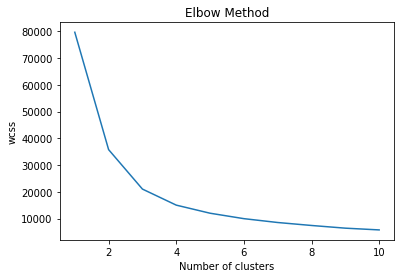

In [59]:
#check for optimal amount of clusters
wcss = []
for i in range(1,11):
    km=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(X_scaled_df)
    wcss.append(km.inertia_)
plt.plot(range(1,11),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

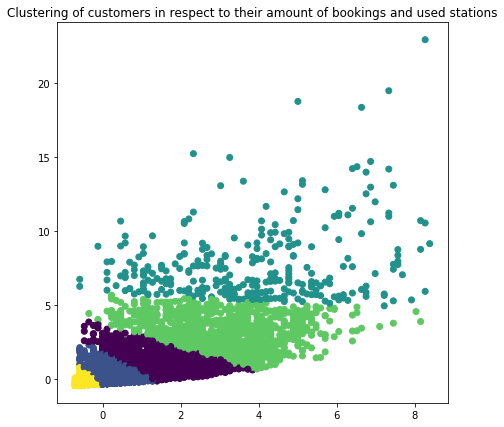

In [60]:
#plot the k-means
means = KMeans(n_clusters=5, init='k-means++', max_iter=300, algorithm='auto')
means.fit(X_scaled_df)
means.predict(X_scaled_df)
x_pred = means.predict(X_scaled_df)
plt.subplots(1, 1, figsize=(7,7))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=x_pred)
plt.title("Clustering of customers in respect to their amount of bookings and used stations")

plt.show()

### Gaussian Mixture

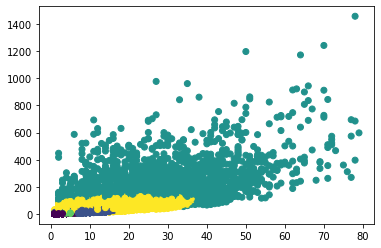

In [61]:
gmm = GaussianMixture(n_components=5).fit(cluster12)
labels = gmm.predict(cluster12)
plt.scatter(cluster12['START_RENTAL_ZONE_HAL_ID'], cluster12['BOOKING_HAL_ID'], c=labels, cmap='viridis')

### Result

This clustering does not really show relevant information. It's basically portraying that there are customers with little amount of bookings at few various stations and then it gets more and more, with the high variance in the outer area is clustered as one cluster, which means that customers with a lot of bookings at a few stations and the other way customers with a lot of different stations but rather few bookings are put into the same cluster which makes no real sense.

# Routes

## Routes to Amount of bookings and customers and duration

### Preparation

In [62]:
#get the routes
#get the amount of bookings per route
#get the amount of unique customers per route
#get the average duration per route
# 
cluster = booking_set_frankfurt_20152016.loc[:,['BOOKING_HAL_ID', 'END_RENTAL_ZONE', 'START_RENTAL_ZONE', 'CUSTOMER_HAL_ID', 'duration']]

In [63]:
a = cluster.groupby(['END_RENTAL_ZONE', 'START_RENTAL_ZONE'], as_index=False)['BOOKING_HAL_ID'].count()

In [64]:
b = cluster.groupby(['END_RENTAL_ZONE', 'START_RENTAL_ZONE'], as_index=False).agg({'CUSTOMER_HAL_ID': pd.Series.nunique})

In [65]:
cluster['duration'] = pd.to_numeric(cluster['duration'])
c = cluster.groupby(['END_RENTAL_ZONE', 'START_RENTAL_ZONE'], as_index=False)['duration'].mean()
c['duration'] = pd.to_timedelta(c['duration'])
c['duration']  = round(c['duration'].dt.total_seconds()/60)

In [66]:
a = a.drop(['END_RENTAL_ZONE', 'START_RENTAL_ZONE'], axis=1)
b = b.drop(['END_RENTAL_ZONE', 'START_RENTAL_ZONE'], axis=1)
c = c.drop(['END_RENTAL_ZONE', 'START_RENTAL_ZONE'], axis=1)

In [67]:
cluster8 = pd.concat([a, b, c], axis=1)
cluster8

,BOOKING_HAL_ID,CUSTOMER_HAL_ID,duration
0,99,26,57.0
1,1,1,13.0
2,4,3,17.0
3,2,2,13.0
4,4,3,9.0
...,...,...,...
47099,3,3,15.0
47100,1,1,18.0
47101,5,2,18.0
47102,7,3,10.0


In [68]:
indexNames = cluster8[ cluster8['BOOKING_HAL_ID'] > 5000 ].index

In [69]:
indexNames

Int64Index([22416, 33188], dtype='int64')

In [70]:
cluster8 = cluster8.drop(indexNames)

In [71]:
indexNames = cluster8[ cluster8['CUSTOMER_HAL_ID'] > 2000 ].index

In [72]:
indexNames

Int64Index([22631], dtype='int64')

In [73]:
cluster8 = cluster8.drop(indexNames)

### sns-plot

If you rerun the code, remember to cluster the first kmeans and then run the first 3D model. Then go to second with more clsuters and run the next 3D model and so on. In total there are 3. Do that since the variable names haven't been changed yet.

In [74]:
#scale values
scaler = StandardScaler()
scaler.fit(cluster8)
X_scaled = scaler.transform(cluster8)
X_scaled_df = pd.DataFrame(X_scaled, columns=cluster8.columns, index=cluster8.index)
X_scaled_df.head()

,BOOKING_HAL_ID,CUSTOMER_HAL_ID,duration
0,0.946707,0.580173,0.108645
1,-0.262646,-0.360587,-0.093463
2,-0.225625,-0.285326,-0.075090
3,-0.250306,-0.322956,-0.093463
4,-0.225625,-0.285326,-0.111837


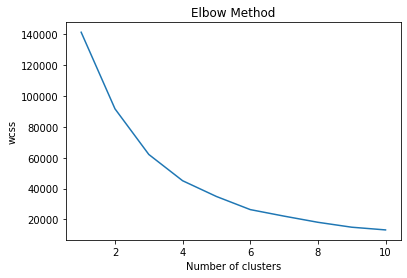

In [75]:
#check for optimal amount of clusters
wcss = []
for i in range(1,11):
    km=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(X_scaled_df)
    wcss.append(km.inertia_)
plt.plot(range(1,11),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

In [79]:
means = KMeans(n_clusters=4)
means.fit(X_scaled)
means.predict(X_scaled)
x_pred = means.predict(X_scaled)

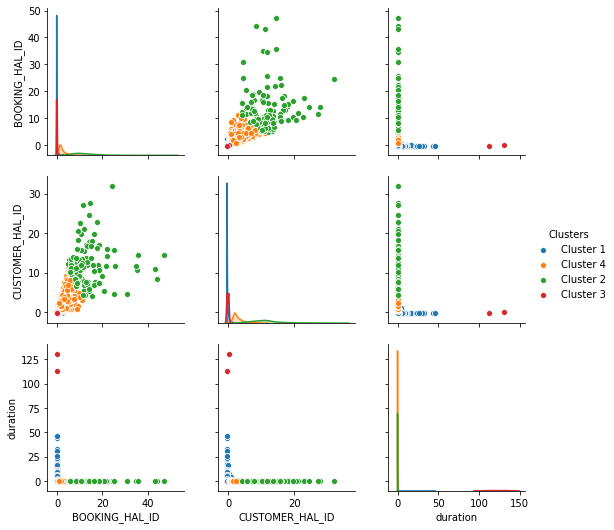

In [80]:
numbers = ["Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4", "Cluster 5", "Cluster 6", "Clusters"]
X_scaled_df["Clusters"] = means.predict(X_scaled)
X_scaled_df["Clusters"] = X_scaled_df["Clusters"].apply(lambda x: numbers[x])
sns.pairplot(data=X_scaled_df, hue="Clusters")

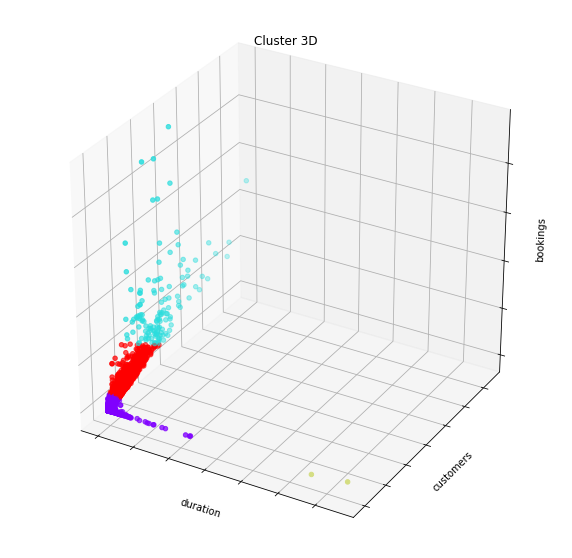

In [81]:
#plot with 4 clusters
zline = np.linspace(0, 15, 1000)
xline = np.sin(zline)
yline = np.cos(zline)

fignum = 1
fig = plt.figure(fignum, figsize=(10, 10))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.plot3D(xline, yline, zline, 'gray')

ax = plt.axes(projection='3d')

ax.scatter3D(X_scaled[:, 2], X_scaled[:, 1], X_scaled[:, 0], c=x_pred, cmap='rainbow')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('duration')
ax.set_ylabel('customers')
ax.set_zlabel('bookings')
ax.set_title('Cluster 3D')
ax.dist = 10

fig.show()

### Result

Actually quite close to the result as before. The duration has the effect of almost linear lines, most customers and bookings have a smal duration. Then there come less and less towards both axes. 
So we do not really get new information regarding certain routes. It's more or less the same distribution as we have seen for just the stations. Also the duration shows the same value before, more bookings for less time and less booking for longer routes. Which also makes sense since less time equals less payment.
